# Self driving car based on NVidia and Udacity Car Simulation

https://dox.abv.bg/download?id=92db0d4c5b# - Линк за сваляне на целия проект ( включително симулацията )

Nvidia са направили CNN, която да може да кара кола. Целта на модела е по само дадена снимка да каже ъгъл на завиване на колата. За целта те са закачили 3 камери на кола и са пуснали шофьор да обикаля 72 часа и да събира данни. Получените данни са малко и затова в/у тях се правят различни трансформации като правене на образа огледален или корекция на страничните камери спрямо централната. С така получения разширен датасет се обучава мрежата да "върти геврека".

nvidia model: https://devblogs.nvidia.com/deep-learning-self-driving-cars/ 

Udacity са направили симулация, с която да се симулира експеримента. Когато "шофираш" се записват данни от 3те камери плюс данните за ъгъл на волана, моментна скорост, тяга.

Udacity sim: https://github.com/udacity/self-driving-car-sim

Additional resources about how to run the model on the simulator: https://github.com/udacity/CarND-Behavioral-Cloning-P3
( общо взето симулатора отваря сокет и в репозиторито има скрипт, който говори с него )

In [15]:
from IPython.display import HTML
from IPython.display import Image

Начални данни се взимат като се правят обиколки

![circle_driving](https://media.giphy.com/media/3orieWKiwpABZ3yUmc/giphy.gif "circle_driving")

Направих 2 обиколки и половина и събрах близо 10 000 снимки. След това върху тези снимки приложих различни промени (augmentations), за да увелича dataset-a до TOTAL_IMAGE_COUNT(60 000) и за да направя алгоритъма по- устойчив. 

На така подготвените данни приложих по-горе споменатия NVidia модел имплеметиран с tf2

In [1]:
%matplotlib inline

In [14]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import pandas as pd

np.random.seed(0)

# Preprocess images to create larger dataset 

In [16]:

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3 # that is the NVidia model input
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

DATA_DIR = "data"
SPLITS_DIR = "splits"
IMG_subdir = "IMG"
IMG_PROCESSED = "IMG_PROCESSED"
IMG_EXTENSION = '.JPG'


ADJUST_FOR_SIDE_IMAGE = 0.2
TOTAL_IMAGE_COUNT = 60000

BATCH_SIZE = 64

TRAIN_PCT, VAL_PCT = 0.9, 0.1

### Preprocess 

In [17]:
def load_image_from_dir(data_dir, image_file):
    #Load RGB images from a file
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def load_image(image_file):
    #Load RGB images from a file
    return mpimg.imread(image_file.strip())

def crop(image):
    #Crop the image (removing the sky at the top and the car front at the bottom)
    return image[60:-25, :, :]

def resize(image):
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

def rgb2yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def normalize_image(image):
    return image/127.5 - 1
    #image = tf.image.resize(image, IMAGE_SIZE) # images should be that size anyway
    #return tf.image.per_image_standardization(image)

def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    #image = normalize_image(image)
    return image

def preprocess_with_norm(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    image = normalize_image(image)
    return image


In [5]:
image = load_image_from_dir(DATA_DIR, 'preprocess.jpg')

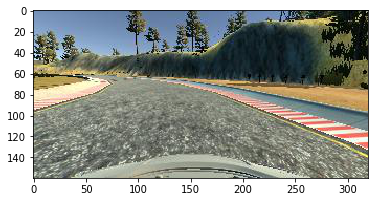

In [15]:
imgplot = plt.imshow(image)

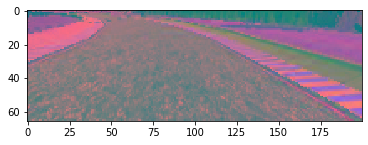

In [16]:
plt.imshow(preprocess(image))

In [52]:
image.shape

(160, 320, 3)

### Augment

In [53]:
def random_translate(image, steering_angle, range_x = 100, range_y = 10):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


In [54]:
image, steer = random_translate(image, 0, 100, 10)

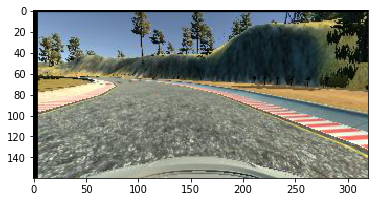

In [55]:
plt.imshow(image)

In [56]:
def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


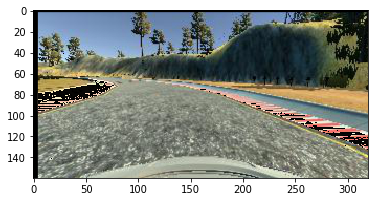

In [57]:
plt.imshow(random_brightness(image))

In [58]:
def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle


1


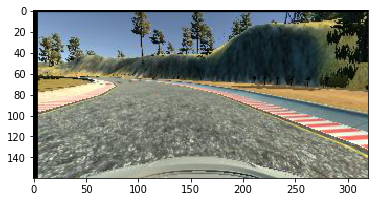

In [59]:
flippedImage, flippedAngle = random_flip(image, 1)
print(flippedAngle)
plt.imshow(flippedImage)

In [60]:
def augment_image(image, steering):
    image = random_brightness(image)
    image, steering = random_flip(image, steering)
    image, steering = random_translate(image, steering)
    
    
    return image, steering

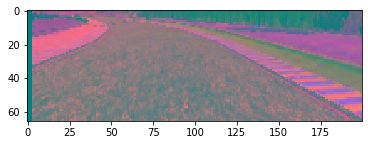

In [61]:
plt.imshow(preprocess(image))

## Generate dataset

In [68]:
data = pd.read_csv('data/driving_log.csv')

In [69]:
data.head()

,center,left,right,steering,trottle,direction,speed
0,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,0.0,0.000000,0,0.232718
1,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,0.0,0.000000,0,0.230856
2,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,0.0,0.000000,0,0.229008
3,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,0.0,0.000000,0,0.227176
4,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,E:\Deep Learning\beta_simulator_windows\data\I...,0.0,0.064408,0,0.267665


In [70]:
data.head().left[0]

'E:\\Deep Learning\\beta_simulator_windows\\data\\IMG\\left_2020_01_31_18_01_37_983.jpg'

В базата данни първите 3 полета са път към снимките съответно от лява, централна и дясна камера. Следват полета за градус на завиване, тяга, посока и скорост. Ние ще използваме само полето за ъгъл на завиване.

In [71]:
data.describe()

,steering,trottle,direction,speed
count,3166.000000,3166.000000,3166.0,3166.000000
mean,-0.036513,0.998035,0.0,29.972235
std,0.133259,0.041860,0.0,2.167875
min,-0.900000,0.000000,0.0,0.227176
25%,0.000000,1.000000,0.0,30.188840
50%,0.000000,1.000000,0.0,30.190180
75%,0.000000,1.000000,0.0,30.190290
max,1.000000,1.000000,0.0,30.598720


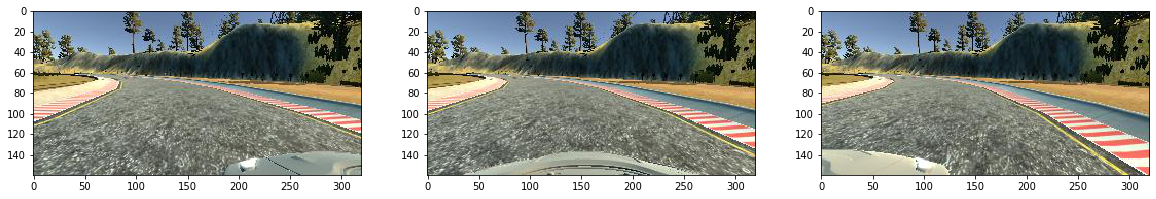

In [72]:
f, axarr = plt.subplots(1,3,figsize=(20, 20))


axarr[0].imshow(load_image(data.left[0]))
axarr[1].imshow(load_image(data.center[0]))
axarr[2].imshow(load_image(data.right[0]))

In [109]:
output_df = pd.DataFrame({ 'image' :[], 'steering': []})

In [110]:
output_df

,image,steering


In [111]:
path = os.path.join(DATA_DIR, IMG_PROCESSED)

if not os.path.exists(path):
    os.makedirs(path)

### Apply preprocess

In [112]:
def processed_pic_id( index ) :
    path = os.path.join(DATA_DIR, IMG_PROCESSED, str(index))
    path = path + IMG_EXTENSION
    return path

In [113]:
def preprocess_left(image_path, steering, index):
    image = load_image(image_path)
    image = preprocess(image)
    steering += ADJUST_FOR_SIDE_IMAGE
    pic_id = processed_pic_id(index)
    mpimg.imsave(pic_id, image)
    return pic_id, steering

def preprocess_right(image_path, steering, index):
    image = load_image(image_path)
    image = preprocess(image)
    steering -= ADJUST_FOR_SIDE_IMAGE
    pic_id = processed_pic_id(index)
    mpimg.imsave(pic_id, image)
    return pic_id, steering

def preprocess_center(image_path, steering, index):
    image = load_image(image_path)
    image = preprocess(image)
    pic_id = processed_pic_id(index)
    mpimg.imsave(pic_id, image)
    return pic_id, steering

In [114]:
for index, row in data.iterrows():
    pic_path = row['center']
    pic_id, steering = preprocess_center(pic_path, row['steering'], output_df.shape[0])
    output_df.loc[output_df.shape[0]]=[pic_id, steering]
    
    pic_path = row['left']
    pic_id, steering = preprocess_left(pic_path, row['steering'], output_df.shape[0])
    output_df.loc[output_df.shape[0]]=[pic_id, steering]
    
    pic_path = row['right']
    pic_id, steering = preprocess_right(pic_path, row['steering'], output_df.shape[0])
    output_df.loc[output_df.shape[0]]=[pic_id, steering]
    

In [115]:
output_df.shape

(9498, 2)

In [116]:
output_df.shape[0]

9498

In [117]:
output_df

,image,steering
0,data\IMG_PROCESSED\0.JPG,0.0
1,data\IMG_PROCESSED\1.JPG,0.2
2,data\IMG_PROCESSED\2.JPG,-0.2
3,data\IMG_PROCESSED\3.JPG,0.0
4,data\IMG_PROCESSED\4.JPG,0.2
...,...,...
9493,data\IMG_PROCESSED\9493.JPG,0.2
9494,data\IMG_PROCESSED\9494.JPG,-0.2
9495,data\IMG_PROCESSED\9495.JPG,0.0
9496,data\IMG_PROCESSED\9496.JPG,0.2


In [118]:
output_df.to_csv("prepared_1.csv", index=False)

### Apply augmentation

In [119]:
index = output_df.shape[0]
total = output_df.shape[0]
while True:
    if index >= TOTAL_IMAGE_COUNT:
        break;
        
    i = np.random.randint(0, high=output_df.shape[0])
    image = load_image(output_df.image[i])
    image, steering = augment_image(image, output_df.steering[i])
    
    path = processed_pic_id(index)
    mpimg.imsave(path, image)
    output_df.loc[output_df.shape[0]]=[path, steering]
   
    index += 1
    
        
    

In [120]:
output_df.to_csv("prepared_2.csv", index=False)

In [17]:
output_df = pd.read_csv("prepared_2.csv")

In [18]:
output_df.shape

(60000, 2)

### Split the data into train and validation data. We don't need test data. We are going to test it on te simulator

In [19]:
train_data, val_data = pd.DataFrame(), pd.DataFrame()

train_data_end = round( TRAIN_PCT * len(output_df) )

output_df = output_df.sample(frac = 1)

train_data = output_df[:train_data_end]
val_data = output_df[train_data_end:]

train_data = train_data.sample(frac = 1)
val_data = val_data.sample(frac = 1)

In [20]:
train_data.shape, val_data.shape

((54000, 2), (6000, 2))

Then, we can save the datasets and load them from files later (so we don't have to regenerate them).

In [21]:
for dataset, filename in zip([train_data, val_data], ["train", "val"]):
    dataset.to_csv(os.path.join(SPLITS_DIR, filename + ".csv"), index = False)

# Data is almost ready now

In [13]:
if not os.path.exists(SPLITS_DIR):
    os.makedirs(SPLITS_DIR)

In [6]:
train_data = pd.read_csv(os.path.join(SPLITS_DIR, "train.csv"))
val_data = pd.read_csv(os.path.join(SPLITS_DIR, "val.csv"))

In [7]:
train_data.shape, val_data.shape

((54000, 2), (6000, 2))

In [8]:
train_data_size = len(train_data)
val_data_size = len(val_data)

In [11]:
def read_and_prepare_image(image_filename, image_steering) :
    
    image = tf.io.read_file(image_filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, IMAGE_SIZE) # images should be that size anyway


    #image = tf.cast(image, tf.float32)
    #image = image / 127.5 - 1
    image = normalize_image(image)
    
    return image, image_steering

    

In [12]:
# Note that we're rewriting variable names in a lot of places. This is not always
# a good practice but we're working in a notebook so: 1) we don't need all variables
# but they're still allocated; 2) we can reuse the same name in a different context
def initialize_tf_dataset(data, should_batch = True, should_repeat = True):
    dataset = tf.data.Dataset.from_tensor_slices((data.image.values, data.steering.values))
    dataset = dataset.map(read_and_prepare_image)
    dataset = dataset.shuffle(buffer_size = len(data))
    
    if should_batch:
        dataset = dataset.batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(len(data))
        
    if should_repeat:
        dataset = dataset.repeat()
    return dataset

train_data = initialize_tf_dataset(train_data)
val_data = initialize_tf_dataset(val_data)

In [ ]:
# Let's look at an example to see if it was created correctly
for batch in train_data:
    print(batch[0].shape, batch[1].shape)
    break

# Different models

In [13]:
def build_model():
    """
    Modified NVIDIA model
    """

    DROPOUT_RATE = 0.2

    model = Sequential()
    #model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(InputLayer(input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, activation='relu', strides=(2, 2)))
    model.add(Conv2D(36, 5, activation='relu', strides=(2, 2)))
    model.add(Conv2D(48, 5, activation='relu', strides=(2, 2)))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.summary()

    return model

In [14]:
def build_model_2():
    """
    Modified NVIDIA model
    """

    DROPOUT_RATE = 0.2

    model = Sequential()
    #model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(InputLayer(input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, activation='relu', strides=(2, 2)))
    model.add(Conv2D(36, 5, activation='relu', strides=(2, 2)))
    model.add(Conv2D(48, 5, activation='relu', strides=(2, 2)))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.summary()

    return model

In [15]:
model = build_model_2()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [20]:


# We're looking at the simplest case, when we have a well-defined loss function
# and easy-to-use metrics
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = "mse",
    metrics = [tf.keras.metrics.MeanSquaredError()])

# Training 

In [21]:
# Note that there might be slightly more, or slightly fewer steps per epoch using this approach.
# Since we're running through the entire dataset multiple times, this is not a problem. We could
# round up or down, without any significant impact on the training.
steps_per_epoch_train = round(train_data_size / BATCH_SIZE)
steps_per_epoch_val = round(val_data_size / BATCH_SIZE)

steps_per_epoch_train, steps_per_epoch_val

(844, 94)

In [22]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

In [23]:
history = model.fit(
    train_data,
    epochs = 20,
    steps_per_epoch = steps_per_epoch_train,
    validation_data = val_data,
    validation_steps = steps_per_epoch_val,
    callbacks = [TensorBoard(), checkpoint])

Train for 844 steps, validate for 94 steps
Epoch 1/20
844/844 [==============================] - 206s 244ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - val_loss: 0.0191 - val_mean_squared_error: 0.0190
Epoch 2/20
844/844 [==============================] - 233s 276ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 3/20
844/844 [==============================] - 211s 249ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 4/20
844/844 [==============================] - 207s 245ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0184 - val_mean_squared_error: 0.0184
Epoch 5/20
844/844 [==============================] - 187s 222ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0182 - val_mean_squared_error: 0.0181
Epoch 6/20
844/844 [==============================] - 183s 217ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0

In [24]:


def build_model_3():
    """
    Modified NVIDIA model
    """

    DROPOUT_RATE = 0.5

    model = Sequential()
    #model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(InputLayer(input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, activation='relu', strides=(2, 2)))
    model.add(Conv2D(36, 5, activation='relu', strides=(2, 2)))
    model.add(Conv2D(48, 5, activation='relu', strides=(2, 2)))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Conv2D(64, 3, activation='relu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.summary()

    return model

In [25]:
model = build_model_3()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [26]:
checkpoint = ModelCheckpoint('model3-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=False,
                                 mode='auto')

In [27]:


# We're looking at the simplest case, when we have a well-defined loss function
# and easy-to-use metrics
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = "mse",
    metrics = [tf.keras.metrics.MeanSquaredError()])

In [28]:
history = model.fit(
    train_data,
    epochs = 40,
    steps_per_epoch = steps_per_epoch_train,
    validation_data = val_data,
    validation_steps = steps_per_epoch_val,
    callbacks = [TensorBoard(), checkpoint])

Train for 844 steps, validate for 94 steps
Epoch 1/40
844/844 [==============================] - 221s 262ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 2/40
844/844 [==============================] - 201s 238ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0257 - val_mean_squared_error: 0.0257
Epoch 3/40
844/844 [==============================] - 228s 270ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 4/40
844/844 [==============================] - 235s 278ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 5/40
844/844 [==============================] - 230s 273ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 6/40
844/844 [==============================] - 203s 241ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0

In [31]:


def build_model_4():
    """
    Modified NVIDIA model
    """

    DROPOUT_RATE = 0.5

    model = Sequential()
    #model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(InputLayer(input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, activation='elu', strides=(2, 2)))
    model.add(Conv2D(36, 5, activation='elu', strides=(2, 2)))
    model.add(Conv2D(48, 5, activation='elu', strides=(2, 2)))
    model.add(Conv2D(64, 3, activation='elu'))
    model.add(Conv2D(64, 3, activation='elu'))
    model.add(Dropout(DROPOUT_RATE))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()

    return model

In [32]:
model = build_model_4()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

In [33]:
checkpoint = ModelCheckpoint('model4-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

In [34]:
# We're looking at the simplest case, when we have a well-defined loss function
# and easy-to-use metrics
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = "mse",
    metrics = [tf.keras.metrics.MeanSquaredError()])

In [36]:
history4 = model.fit(
    train_data,
    epochs = 40,
    steps_per_epoch = steps_per_epoch_train,
    validation_data = val_data,
    validation_steps = steps_per_epoch_val,
    callbacks = [TensorBoard(log_dir='logs\model4', histogram_freq=1), checkpoint])

Train for 844 steps, validate for 94 steps
Epoch 1/40
844/844 [==============================] - 309s 367ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 2/40
844/844 [==============================] - 241s 285ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 3/40
844/844 [==============================] - 297s 352ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0313 - val_mean_squared_error: 0.0313
Epoch 4/40
844/844 [==============================] - 299s 354ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 5/40
844/844 [==============================] - 260s 309ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 6/40
844/844 [==============================] - 238s 282ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0

# Резултати

Видеата, които следват са от Model3()

In [26]:
# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/jQqffbdbFy8?rel=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


In [27]:
# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/Ax_jr6j3NTU?rel=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


Интересно, че колата се държи по този начин. В завоите доста стабилно, но на правата като че ли не иска да върви в една линия. Пробвах с различни варианти за регуларизация, различен learning rate и да обучавам повече епохи. Това ме навежда на мисълта, че не съм си подготвил достатъчно добре данните.


Model1 също успява да направи цяла обиколка на пистата. Него го бях обучил само за 20 епохи. При него също също се получаваше "шаренето" по лентите.

![dog_driving](https://media.giphy.com/media/qElYcBzFWeSZi/giphy.gif "dog_driving")

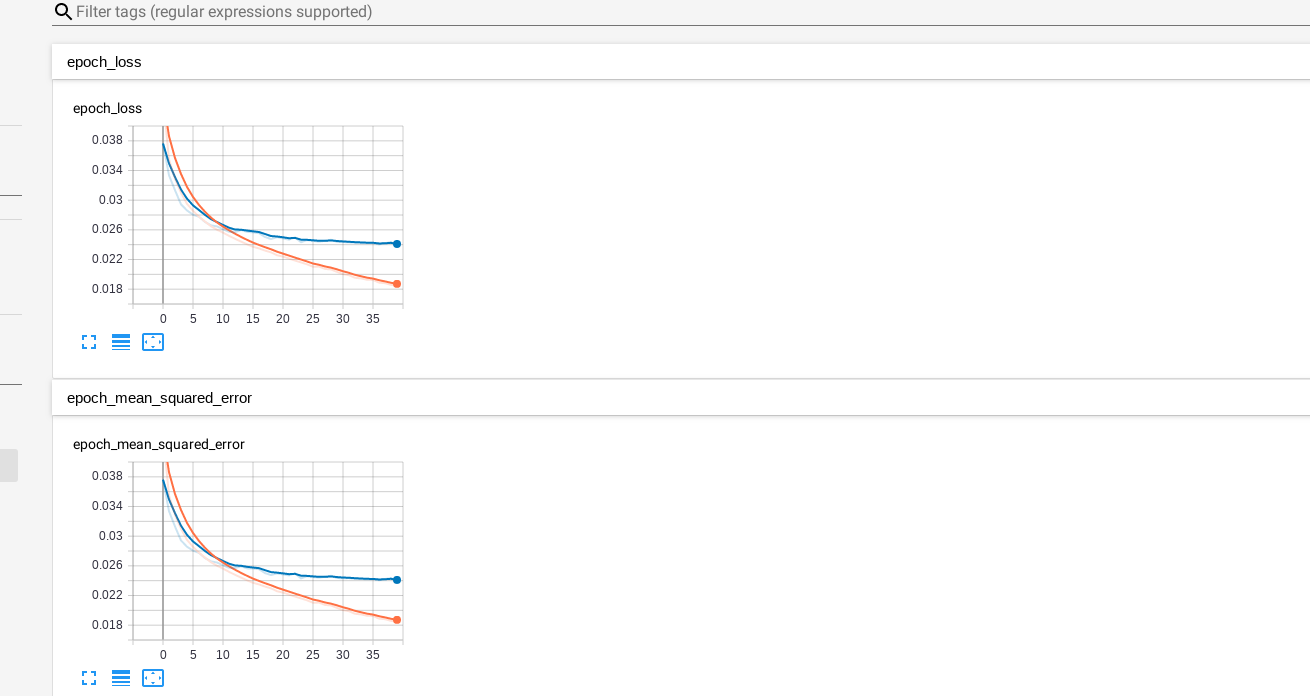

In [20]:
Image(filename='tensorboard.png') 

Моделът има склонност да overfit-ва. Пробвах различни варианти на регуларизация, но не съм доволен. Следваща стъпка за подобряване на модела е да събера повече и разнородни данни и да обучавам и с тях. За целта в симулатора мога да направя още писти, от които да направя още данни. Вероятно тогава моделът няма да шофира като пиян.

![not_drunk](https://media.giphy.com/media/3ornkdsG21TzWOj71u/giphy.gif "not_drunk")